In [483]:
import numpy as np
import GPy as gpy
from vtk import *
from vtk.util.numpy_support import numpy_to_vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

In [484]:
numofinterpolneighbors = 10

In [485]:
#plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use(['seaborn-poster'])
#seaborn-paper
#seaborn-poster
#seaborn-notebook
#seaborn-talk
#plt.rcParams['lines.linewidth']= 2.0
#plt.rcParams['lines.color']= 'black'
#plt.rcParams['legend.frameon']=True
plt.rcParams['figure.figsize'] = (8, 6)
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['legend.fontsize']=14
#plt.rcParams['font.size'] = 14
#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.left'] = True
#plt.rcParams['axes.spines.bottom'] = True
#plt.rcParams['axes.axisbelow'] = True

In [486]:
reader = vtkXMLUnstructuredGridReader()
reader.SetFileName("mesh.vtu")
reader.Update()
output = reader.GetOutput()
p = output.GetPointData()
points = vtk_to_numpy(output.GetPoints().GetData())

In [487]:
r = np.linspace(0,50)

In [488]:
def f(x):
    return 2.5*np.exp(-x*x/73)

In [489]:
press = np.zeros(len(points))
for i in range(len(points)):
    r=np.sqrt(points[i][0]*points[i][0]+points[i][1]*points[i][1]+points[i][2]*points[i][2])
    press[i] = f(r)

In [490]:
p.AddArray(numpy_to_vtk(press))
p.GetArray(0).SetName("pressure")

In [491]:
writer = vtkXMLUnstructuredGridWriter()
writer.SetFileName("mesh.vtu")
writer.SetInputData(output)
writer.Write()

1

In [492]:
reader = vtkXMLUnstructuredGridReader()
reader.SetFileName("mesh.vtu")
reader.Update()
output = reader.GetOutput()
pressure_vtk = vtk_to_numpy(output.GetPointData().GetArray(0))
points = vtk_to_numpy(output.GetPoints().GetData())

In [493]:
import pandas as pd

In [494]:
df = pd.DataFrame(points)

In [495]:
df["pressure"] = pressure_vtk

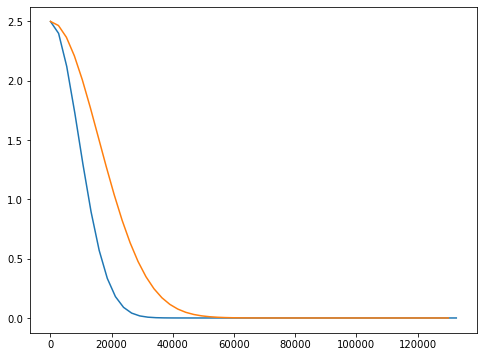

In [496]:
plt.plot(df[(df[0]==df[1]) & (df[1]==df[2])]["pressure"])
plt.plot(df[(df[0]<0.001) & (df[1]<0.001)]["pressure"])

## 10 random points within l_i=10

In [497]:
x_interpol = np.random.rand(numofinterpolneighbors)*50
y_interpol = np.random.rand(numofinterpolneighbors)*50
z_interpol = np.random.rand(numofinterpolneighbors)*50

In [498]:
x_interpol

array([18.71525375, 31.60907672, 13.09497322, 46.94430979,  1.92584909,
        4.35256084, 41.74381754, 26.17027804,  6.53743922, 29.15858284])

In [499]:
points_interpol=np.column_stack((x_interpol, y_interpol, z_interpol))

In [500]:
points_interpol[1][1]

18.935128027913116

In [501]:
len(points_interpol)

10

Get adjacent points

In [502]:
time_dict={}

In [503]:
a = time.time()

In [504]:
def getNeighbors(points_interpol, df):
    neighbors = {}
    for i in range(len(points_interpol)):
        df["r_"+str(i)]=(df[0]-points_interpol[i][0])*(df[0]-points_interpol[i][0])+(df[1]-points_interpol[i][1])*(df[1]-points_interpol[i][1])+(df[2]-points_interpol[i][2])*(df[2]-points_interpol[i][2])
        neighbors[i] = df.sort_values(by=["r_"+str(i)]).head(14).index
    return neighbors

In [505]:
nb = getNeighbors(points_interpol, df)

In [506]:
nb

{0: Int64Index([110740, 110739, 110791, 108139, 113341, 110790, 110689, 108138,
             113340, 110741, 108190, 113392, 110688, 108189],
            dtype='int64'),
 1: Int64Index([11405, 11404, 14006, 14005, 11354, 11353, 11456, 13955, 11455,
             13954, 14057, 14056,  8804, 11406],
            dtype='int64'),
 2: Int64Index([101503, 101554, 101504, 104104,  98902, 101502, 101452, 101555,
             104155, 104105,  98953, 101553,  98903, 104103],
            dtype='int64'),
 3: Int64Index([60788, 60839, 63389, 60787, 63440, 60838, 60789, 58187, 60840,
             58238, 63388, 63439, 60737, 63390],
            dtype='int64'),
 4: Int64Index([89099, 91700, 89048, 91649, 89098, 91699, 89100, 89047, 91701,
             91648, 89049, 91650, 89150, 91751],
            dtype='int64'),
 5: Int64Index([ 98587,  98588,  98638,  95986,  98639,  95987,  96037,  96038,
             101188,  98536,  98586, 101189,  98537, 101239],
            dtype='int64'),
 6: Int64Index([110406

In [507]:
b= time.time()
time_dict["neighbor search"] = b-a

## Grid method neighbor + linear interpol

In [508]:
a = time.time()

In [509]:
resp_n = []
resp_l = []

In [510]:
for i,_ in enumerate(x_interpol):
    grid_x, grid_y, grid_z = np.mgrid[x_interpol[i]:(x_interpol[i]+0.1):1, y_interpol[i]:(y_interpol[i]+0.1):1, z_interpol[i]:(z_interpol[i]+0.1):]
    resp_n.append(griddata(points[nb[i]], pressure_vtk[nb[i]], (grid_x, grid_y, grid_z), method='nearest')[0][0][0])
    resp_l.append(griddata(points[nb[i]], pressure_vtk[nb[i]], (grid_x, grid_y, grid_z), method='linear')[0][0][0])

In [511]:
b= time.time()
time_dict["grid interpol"] = b-a

In [512]:
resp_ana = f(np.sqrt((x_interpol*x_interpol+y_interpol*y_interpol+z_interpol*z_interpol)))

In [513]:
resp_n

[5.655821787175936e-18,
 1.1562599947424437e-08,
 2.1765871012692683e-10,
 1.518338927295272e-18,
 3.100278740600838e-08,
 3.712381465595856e-21,
 3.385253707735704e-24,
 7.217431932529809e-27,
 3.253981404314925e-14,
 1.2062323896372312e-09]

In [514]:
resp_l

[6.347096523247135e-18,
 1.7757303693588097e-08,
 1.9936913168052444e-10,
 1.3542673993063e-18,
 2.4131322526414304e-08,
 4.426856803430931e-21,
 5.213686622376216e-24,
 1.2881729032524841e-26,
 5.821929574980145e-14,
 1.0765270577115117e-09]

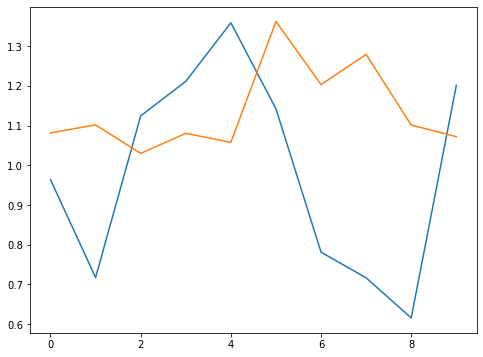

In [515]:
plt.plot(resp_n/resp_ana)
plt.plot(resp_l/resp_ana)

# all at once:

In [516]:
a = time.time()

In [517]:
ker = gpy.kern.Matern52(3,ARD=True)

In [518]:
new_nb = []
for i in nb:
    for j in range(len(nb[i])):
        new_nb.append(nb[i][j])

In [519]:
pressure_vtk_ = np.zeros((len(pressure_vtk[new_nb]),1), dtype=np.float32)
pressure_vtk_[:,0] = pressure_vtk[new_nb] 

In [520]:
m = gpy.models.GPRegression(points[new_nb],pressure_vtk_, ker, noise_var=1.e-10)

In [521]:
m.optimize(optimizer='scg', messages=False, max_iters = 1000)

In [522]:
resp_gpy = m.predict(points_interpol)

In [523]:
resp_gpy[0][:,0]

array([1.42322197e-18, 3.06997969e-18, 2.23425919e-18, 1.15471729e-18,
       3.75681676e-18, 6.84948404e-19, 5.95224573e-19, 5.05594959e-19,
       1.34233320e-18, 2.76970190e-18])

In [524]:
b= time.time()
time_dict["GPy1"] = b-a

In [525]:
nb[1]

Int64Index([11405, 11404, 14006, 14005, 11354, 11353, 11456, 13955, 11455,
            13954, 14057, 14056,  8804, 11406],
           dtype='int64')

In [526]:
a = time.time()

In [527]:
m2 = {}
resp_gpy2 = []
for i in range(len(points_interpol)):
    pressure_vtk_ = np.zeros((len(pressure_vtk[nb[i]]),1), dtype=np.float64)
    pressure_vtk_[:,0] = pressure_vtk[nb[i]]
    ker = gpy.kern.Matern52(3,ARD=True)
    m2[i] = gpy.models.GPRegression(points[nb[i]],pressure_vtk_, ker, noise_var=1.e-10)
    m2[i].optimize(optimizer='scg', messages=False, max_iters = 1000)
    y = np.zeros((1,3))
    y[0,:] = points_interpol[i]
    resp_gpy2.append(m2[i].predict(y)[0][0][0])

In [528]:
b= time.time()
time_dict["GPy2"] = b-a

In [529]:
resp_gpy2

[4.1130640887406687e-20,
 5.565764169701583e-11,
 1.0976723803972706e-12,
 7.794406158000796e-21,
 7.36807784718977e-11,
 2.026063192497279e-23,
 3.706232945962186e-26,
 8.354925133663944e-29,
 3.106584934017083e-16,
 5.190155258260845e-12]

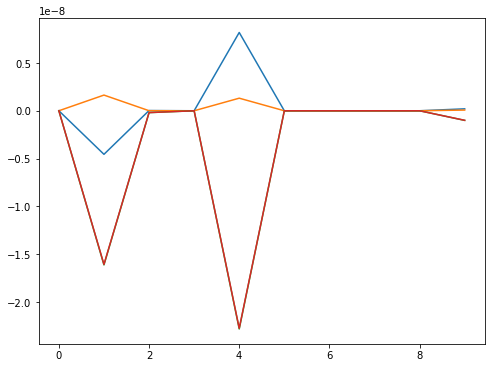

In [530]:
plt.plot((resp_n-resp_ana))
plt.plot((resp_l-resp_ana))
plt.plot((resp_gpy[0][:,0]-resp_ana))
plt.plot((resp_gpy2-resp_ana))

In [531]:
(resp_gpy[0][:,0]-resp_ana)

array([-4.44485276e-18, -1.61170016e-08, -1.93582498e-10, -9.87811444e-20,
       -2.28158765e-08,  6.81698540e-19,  5.95220240e-19,  5.05594949e-19,
       -5.28632676e-14, -1.00419124e-09])

In [532]:
resp_ana

array([5.86807473e-18, 1.61170016e-08, 1.93582501e-10, 1.25349843e-18,
       2.28158765e-08, 3.24986338e-21, 4.33328716e-24, 1.00698613e-26,
       5.28646099e-14, 1.00419124e-09])

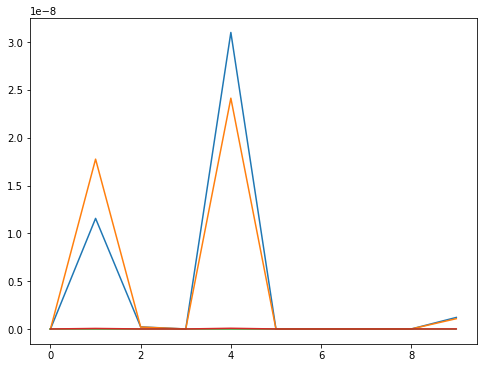

In [533]:
plt.plot(resp_n)
plt.plot(resp_l)
plt.plot(resp_gpy[0][:,0])
plt.plot(resp_gpy2)

## Errors:

In [534]:
(resp_n-resp_ana).std()

2.938036782343206e-09

In [535]:
(resp_l-resp_ana).std()

5.920992217976312e-10

In [536]:
(resp_gpy[0][:,0]-resp_ana).std()

7.876042712272646e-09

In [537]:
(resp_gpy2-resp_ana).std()

7.850150704944159e-09

## Time:

In [538]:
time_dict

{'neighbor search': 0.2154088020324707,
 'grid interpol': 0.024600982666015625,
 'GPy1': 0.21864104270935059,
 'GPy2': 0.5571577548980713}